# CIFAR10 Classfication

We a simple example to demonstrate how to use tensorflow datasets and tf2.3. This time we will use keras-tuner to pick the optimal set of hyperparameters.

18-Aug-2020: Fails to run after the screen locks, hacks `!ls -l` does not seem to work

@date: 17-Aug-2020 | @author: katnoria

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
import IPython
import kerastuner as kt

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [5]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [6]:

IMG_SIZE = 32
NUM_CLASSES = metadata.features["label"].num_classes
print(f"Classes: {NUM_CLASSES}")

Classes: 10


In [7]:
IMG_SIZE = 32
# test
train_ds = ds_train \
    .cache() \
    .batch(1, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

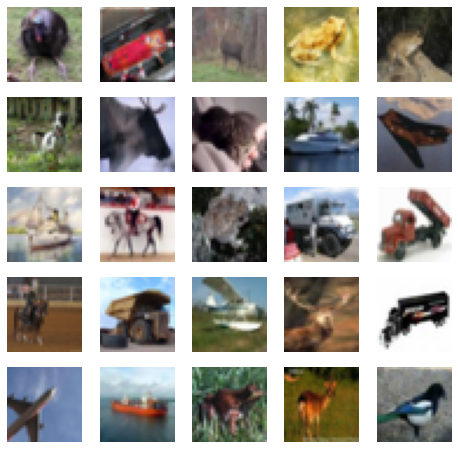

In [8]:
examples = ds_train.take(64)

fig, axs = plt.subplots(5, 5, figsize=(8,8))

for record, ax in zip(examples, axs.flat):
    image, _ = record
    ax.imshow(image)
    ax.axis('off')
plt.show()    

In [9]:
# we no longer need it
del train_ds

In [10]:
# Base Model
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

# Data Augmentation

In [11]:
def transforms(x, hp):
  use_rotation = hp.Boolean('use_rotation')
  if use_rotation:
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(
        hp.Float('rotation_factor', min_value=0.05, max_value=0.2)
    )(x)

  use_zoom = hp.Boolean('use_zoom')
  if use_zoom:
    x = tf.keras.layers.experimental.preprocessing.RandomZoom(
        hp.Float('use_zoom', min_value=0.05, max_value=0.2)
    )(x)

  x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')(x)
  return x

In [12]:
  # Load dataset
  (ds_train, ds_test), metadata = tfds.load(
      'cifar10', split=['train', 'test'], shuffle_files=True, 
      with_info=True, as_supervised=True
      )

In [13]:
num_train_examples=len(ds_train)

In [14]:
# create train and test batch
BS = 128
train_ds = ds_train \
  .cache() \
  .shuffle(num_train_examples).batch(BS, drop_remainder=True) \
  .prefetch(tf.data.experimental.AUTOTUNE) 
  
test_ds = ds_test \
    .cache() \
    .batch(BS, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE)       


In [15]:
def model_builder(hp):
  inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))    
  x = transforms(inputs, hp)
  x = tf.keras.applications.resnet.preprocess_input(x)
  x = base_model(x, training=False)
  hp_num_filters = hp.Int('filters', min_value=32, max_value=512, step=32)
  hp_activation = hp.Choice('activation', values=['relu', 'selu', 'elu'])  
  x = Conv2D(hp_num_filters, 2, padding='same', input_shape=(1,1,2048), activation=hp_activation)(x)
  hp_drop_rate = hp.Float('rate', min_value=0.1, max_value=0.8, step=0.1)  
  x = Dropout(hp_drop_rate)(x)
  x = GlobalAveragePooling2D()(x)  
  x = Dropout(hp_drop_rate)(x)
  use_dense = hp.Boolean('use_dense')
  if use_dense:
    num_dense_units = hp.Int('units', min_value=32, max_value=1024, step=32)
    x = Dense(num_dense_units)(x)
    x = Dropout(hp_drop_rate)(x)
  outputs = Dense(NUM_CLASSES)(x)
  model = tf.keras.Model(inputs, outputs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )

  return model

In [16]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

# Hyperband

In [17]:
tuner = kt.Hyperband(
    model_builder, objective='val_accuracy',  
    max_epochs = 100, factor = 3, project_name = 'cifar10-kt'
    )

tuner.search(
    train_ds, epochs = 100, validation_data = test_ds, 
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=3), ClearTrainingOutput()]
    )

Epoch 1/100
388/390 [============================>.] - ETA: 0s - loss: 8.0442 - accuracy: 0.07 - ETA: 5s - loss: 8.1152 - accuracy: 0.09 - ETA: 5s - loss: 7.7493 - accuracy: 0.10 - ETA: 5s - loss: 7.3000 - accuracy: 0.11 - ETA: 5s - loss: 6.9399 - accuracy: 0.14 - ETA: 5s - loss: 6.7067 - accuracy: 0.14 - ETA: 5s - loss: 6.5303 - accuracy: 0.15 - ETA: 5s - loss: 6.3561 - accuracy: 0.16 - ETA: 5s - loss: 6.2565 - accuracy: 0.16 - ETA: 5s - loss: 6.1681 - accuracy: 0.16 - ETA: 5s - loss: 6.0668 - accuracy: 0.17 - ETA: 5s - loss: 5.9684 - accuracy: 0.17 - ETA: 5s - loss: 5.9220 - accuracy: 0.17 - ETA: 5s - loss: 5.8515 - accuracy: 0.17 - ETA: 5s - loss: 5.7692 - accuracy: 0.17 - ETA: 5s - loss: 5.7097 - accuracy: 0.17 - ETA: 5s - loss: 5.6480 - accuracy: 0.18 - ETA: 5s - loss: 5.5796 - accuracy: 0.18 - ETA: 5s - loss: 5.5469 - accuracy: 0.18 - ETA: 4s - loss: 5.5032 - accuracy: 0.18 - ETA: 4s - loss: 5.4700 - accuracy: 0.18 - ETA: 4s - loss: 5.4380 - accuracy: 0.18 - ETA: 4s - loss: 5.395

390/390 [==============================] - 8s 21ms/step - loss: 3.6333 - accuracy: 0.2266 - val_loss: 1.3844 - val_accuracy: 0.5048
Epoch 2/100
390/390 [==============================] - ETA: 0s - loss: 2.2797 - accuracy: 0.26 - ETA: 4s - loss: 2.1301 - accuracy: 0.26 - ETA: 5s - loss: 2.1337 - accuracy: 0.28 - ETA: 5s - loss: 2.1151 - accuracy: 0.28 - ETA: 5s - loss: 2.1164 - accuracy: 0.28 - ETA: 5s - loss: 2.1022 - accuracy: 0.28 - ETA: 5s - loss: 2.1135 - accuracy: 0.28 - ETA: 5s - loss: 2.1088 - accuracy: 0.28 - ETA: 5s - loss: 2.1123 - accuracy: 0.28 - ETA: 5s - loss: 2.1108 - accuracy: 0.28 - ETA: 5s - loss: 2.1055 - accuracy: 0.28 - ETA: 5s - loss: 2.1023 - accuracy: 0.28 - ETA: 5s - loss: 2.0937 - accuracy: 0.28 - ETA: 5s - loss: 2.0933 - accuracy: 0.28 - ETA: 5s - loss: 2.0838 - accuracy: 0.28 - ETA: 5s - loss: 2.0738 - accuracy: 0.28 - ETA: 5s - loss: 2.0646 - accuracy: 0.28 - ETA: 4s - loss: 2.0573 - accuracy: 0.28 - ETA: 4s - loss: 2.0550 - accuracy: 0.28 - ETA: 4s - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'use_rotation': False,
 'use_zoom': False,
 'filters': 288,
 'activation': 'relu',
 'rate': 0.1,
 'use_dense': True,
 'learning_rate': 0.0001,
 'rotation_factor': 0.14026847996187553,
 'units': 96,
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 4,
 'tuner/round': 3,
 'tuner/trial_id': '5fe2026c9c39e99a7624a2ead669c870'}

In [21]:
path = "models"

import pickle
pickle.dump(best_hyperparameters.values, open(f"{path}/hyperband_params.pkl", "wb"))

best_model.save_weights(f"{path}/hyperband_best_model")

# Random Search

In [ ]:
tuner = kt.tuners.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=100,
    overwrite=True
)

callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, baseline=0.9),
             ClearTrainingOutput()
             ]


tuner.search(train_ds, epochs=100, callbacks=callbacks, validation_data=train_ds)

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'activation': 'relu',
 'filters': 352,
 'learning_rate': 0.0001,
 'rate': 0.2,
 'rotation_factor': 0.17214077598945582,
 'use_rotation': False,
 'use_zoom': False}

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.evaluate(test_ds)

78/78 [==============================] - 2s 31ms/step - loss: 0.9429 - accuracy: 0.6688


[0.9428843855857849, 0.6687700152397156]

In [ ]:
# Keep notebook alive
!ls -l

total 20
drwx------   4 root root  4096 Aug 19 00:29 gdrive
drwxr-xr-x   1 root root  4096 Jul 30 16:30 sample_data
drwxr-xr-x 102 root root 12288 Aug 19 02:12 untitled_project


In [ ]:
path = "/content/gdrive/My Drive/mldrive/models/cifar10/transfer-learning"

import pickle
pickle.dump(best_hyperparameters.values, open(f"{path}/randomsearch_learning_params.pkl", "wb"))

best_model.save_weights(f"{path}/randomsearch_best_model")

# Keras Code 
Code from https://github.com/keras-team/keras-tuner/blob/master/examples/cifar10.py

In [ ]:
import kerastuner as kt
import tensorflow as tf
import tensorflow_datasets as tfds


def build_model(hp):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
    x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    return model


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    directory="/content/gdrive/My Drive/mldrive/models/cifar10-kt",
    project_name='cf10-fullsearch'
    )

data = tfds.load('cifar10')
train_ds, test_ds = data['train'], data['test']


def standardize_record(record):
    return tf.cast(record['image'], tf.float32) / 255., record['label']


train_ds = train_ds.map(standardize_record).cache().batch(64).shuffle(10000)
test_ds = test_ds.map(standardize_record).cache().batch(64)

tuner.search(train_ds,
             validation_data=test_ds,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1), ClearTrainingOutput()],
             )

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
best_hyperparameters.values

{'conv_blocks': 5,
 'dropout': 0.0,
 'filters_0': 128,
 'filters_1': 160,
 'filters_2': 160,
 'filters_3': 192,
 'filters_4': 224,
 'hidden_size': 80,
 'learning_rate': 0.0025359172395390105,
 'pooling_0': 'max',
 'pooling_1': 'max',
 'pooling_2': 'max',
 'pooling_3': 'max',
 'pooling_4': 'max',
 'tuner/bracket': 2,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/round': 2,
 'tuner/trial_id': 'b780a5e9191d55c360ad5be6040decc4'}

In [ ]:
best_model.evaluate(test_ds)

157/157 [==============================] - 1s 7ms/step - loss: 0.5936 - accuracy: 0.8021


[0.5936421751976013, 0.8021000027656555]

In [ ]:
path = "/content/gdrive/My Drive/mldrive/models/cifar10-kt"

import pickle
pickle.dump(best_hyperparameters.values, open(f"{path}/transfer_learning_params.pkl", "wb"))

In [ ]:
best_model.save_weights("/content/gdrive/My Drive/mldrive/models/cifar10-kt/best_model")

In [ ]:
!ls

gdrive	sample_data  untitled_project
